# Traffic Sign Recognizer 

The [German Traffic Sign Recognition Benchmark](http://benchmark.ini.rub.de/?section=gtsrb&subsection=dataset) (GTSRB) is a multi class benchmark with 43 classes of Traffic signs with unbalanced class frequencies, totalling 50k images of traffic signs. 

The benchmark captures real world examples of traffic signs as it reflects th strong variations in visual appearance of signs due to distance, illumination, weather conditions, partial occlusion, and rotations. 

Building a traffic sign recognizer for GTRSB involved the following steps
* Exploratory Visualization 
* Model creation 
* Model Evaluation 
* Model Improvement 



I will define some utility functions and import reqired libraries before moving to the pipeline 

In [80]:
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import cv2
import numpy as np
import os
import glob
import csv
import random
import tensorflow as tf
from tensorflow.contrib.layers import flatten
import math
import time
import datetime
import logging
import sklearn.preprocessing
tf.logging.set_verbosity(tf.logging.INFO)

from sklearn.utils import shuffle

ts = time.time()
st = datetime.datetime.fromtimestamp(ts).strftime('%Y-%m-%d %H:%M:%S')
log_file_ = "../log/log"+st+".log"
logging.basicConfig(filename=log_file_,level=logging.DEBUG,format='%(message)s')


seed = 21
random.seed(seed)
np.random.seed(seed)

In [81]:
import pickle

# TODO: Fill this in based on where you saved the training and testing data

training_file = "../data/traffic-signs-data/train.p"
validation_file = "../data/traffic-signs-data/valid.p"
testing_file = "../data/traffic-signs-data/test.p"

with open(training_file, mode='rb') as f:
    train = pickle.load(f)
with open(validation_file, mode='rb') as f:
    valid = pickle.load(f)
with open(testing_file, mode='rb') as f:
    test = pickle.load(f)

X_train, y_train = train['features'], train['labels']
X_valid, y_valid = valid['features'], valid['labels']
X_test, y_test = test['features'], test['labels']

# Load the label names
label_names_file = "../data/traffic-signs-data/signnames.csv"
label_df = pd.read_csv(label_names_file)

print("Number of original training samples", X_train.shape[0])

Number of original training samples 34799


In [82]:
def bgr2rgb(image_bgr): # convert BGR to RGB 
    image_rgb = cv2.cvtColor(image_bgr, cv2.COLOR_BGR2RGB)
    return image_rgb

def grayscale_normalize_shuffle(images,y):
    gray_images = np.sum(images/3, axis = 3, keepdims = True)
    gray_norm_images = (gray_images - 128)/128  # normalize data set
    images_shuffled, y_shuffled = shuffle(gray_norm_images, y,random_state=seed)
    return images_shuffled,y_shuffled
    

In [83]:
def show_images_with_title(images, cols = 10,cmap = None, titles =list()): #Display a list of bgr images in a grid 
    
    rows = (len(images)+1)/cols
    plt.figure(figsize=(10,10))
    for (i,image,title) in zip(range(len(images)),images,titles):
        ax = plt.subplot(rows,cols,i+1)
        ax.set_title(title,fontweight="bold", size=10)
        if len(image.shape) > 2:
            cmap = 'BrBG'
            #image = bgr2rgb(image)
        else:
            cmap='gray'
        plt.imshow(image,cmap)
        plt.axis('off')
    plt.show()

In [84]:
   
def show_images(images, cmap = None): #Display a list of images in a grid 
    cols = 10
    rows = (len(images)+1)/cols
    plt.figure(figsize=(60,10))
    for i, image in enumerate(images):
        image.shape
        plt.subplot(rows,cols,i+1)
        if len(image.shape) > 2:
            cmap = 'BrBG'
        else:
            cmap='gray'
        plt.imshow(image,cmap)
    plt.show()

In [85]:
def rgb2bgr(image_rgb): # convert RGB to BGR
    return cv2.cvtColor(image_rgb,cv2.COLOR_RGB2BGR)

In [86]:
def histogram_equalization(image):
    img_output = image
    if(len(image.shape)>2):
        img_ycrcb = cv2.cvtColor(image, cv2.COLOR_RGB2YCrCb)
        y, cr, cb = cv2.split(img_ycrcb)
        y_eq = cv2.equalizeHist(y)
        img_ycrcb_eq = cv2.merge((y_eq,cr,cb))
        img_output = cv2.cvtColor(img_ycrcb_eq, cv2.COLOR_YCrCb2RGB)
    else:
        img_output = cv2.equalizeHist(image)
    return img_output

In [87]:
def rand_rotation(image):
    range = 30
    row, col, _ = image.shape
    ang = random.uniform(0, range) - range / 2
    M_rot = cv2.getRotationMatrix2D((col / 2, row / 2), ang, 1)
    return cv2.warpAffine(image, M_rot, (col, row))


def rand_scaling(image):
    row, col, _ = image.shape
    scale_factor = random.uniform(0.0, 1.0) + 1.1
    return cv2.resize(image, (0, 0), fx=scale_factor, fy=scale_factor)


def crop32x32(image):
    center_x, center_y = image.shape[0] / 2, image.shape[1] / 2
    center_x = int(center_x)
    center_y = int(center_y)
    img_crop = image[(center_x - 16):(center_x + 16), (center_y - 16):(center_y + 16)]
    return img_crop

def geom_proc(image):
    rotated = rand_rotation(image)
    scaled = rand_scaling(rotated)
    cropped_image = crop32x32(scaled)
    return cropped_image


    
        

In [88]:
def sharpen(image):
    kernel = np.array([[-1,-1,-1], [-1,9,-1], [-1,-1,-1]])
    return cv2.filter2D(image, -1, kernel)

In [89]:
def save_dict(dict, file):
    with open(file, 'wb') as f:
        pickle.dump(dict, f)

def load_dict(file):
    with open(file, 'rb') as f:
        dict = pickle.load(f)
    return dict

In [90]:
def hbarplot(labels,values, title = 'title',xlabel = 'label',ylabel='count',xsize = 10,ysize =60):
    #print(labels[0][1])
    #plt.figure(figsize=(xsize,ysize))
    fig, ax = plt.subplots()
    fig.set_size_inches(18.5, 18.5)
    width = 0.75 # the width of the bars 
    ind = np.arange(len(values))  # the x locations for the groups
    ax.barh(ind, values, width, color="blue")
    ax.set_yticks(ind+width/2)
    ax.set_yticklabels(labels, minor=False)
    for i, v in enumerate(values):
        ax.text(v, i + .25, str(v), color='red', fontweight='bold')
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel) 
    plt.show()

## Step 0: Exploratory Visualization 

It is an essential task in any machine learning modelling activity to get an exploratory overview of  your data. This helps in improving the performance by tuning parameters to suit your data. 




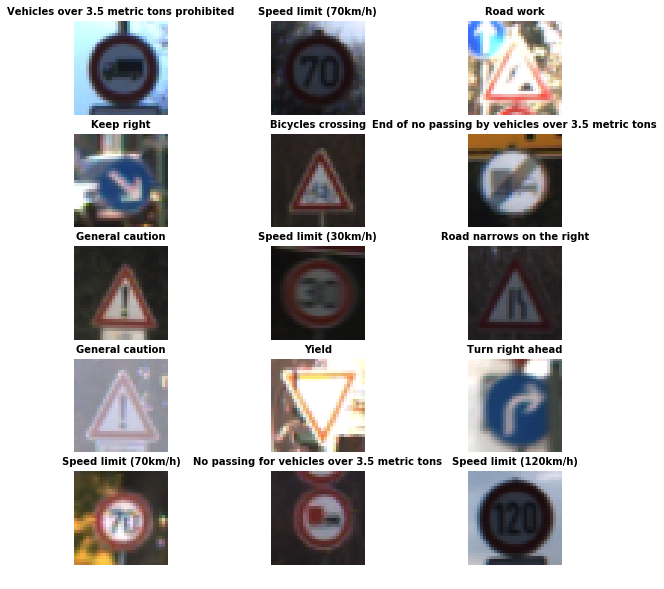

In [91]:
images_sample, y_sample = shuffle(X_train, y_train,n_samples=15, random_state=seed)
titles = label_df['SignName'][y_sample]
show_images_with_title(images_sample,cols = 3,titles = titles)

#### Visualization of class label frequencies

Training samples in the provided dataset are unbalanced, ie the number of training samples for classes are different. 

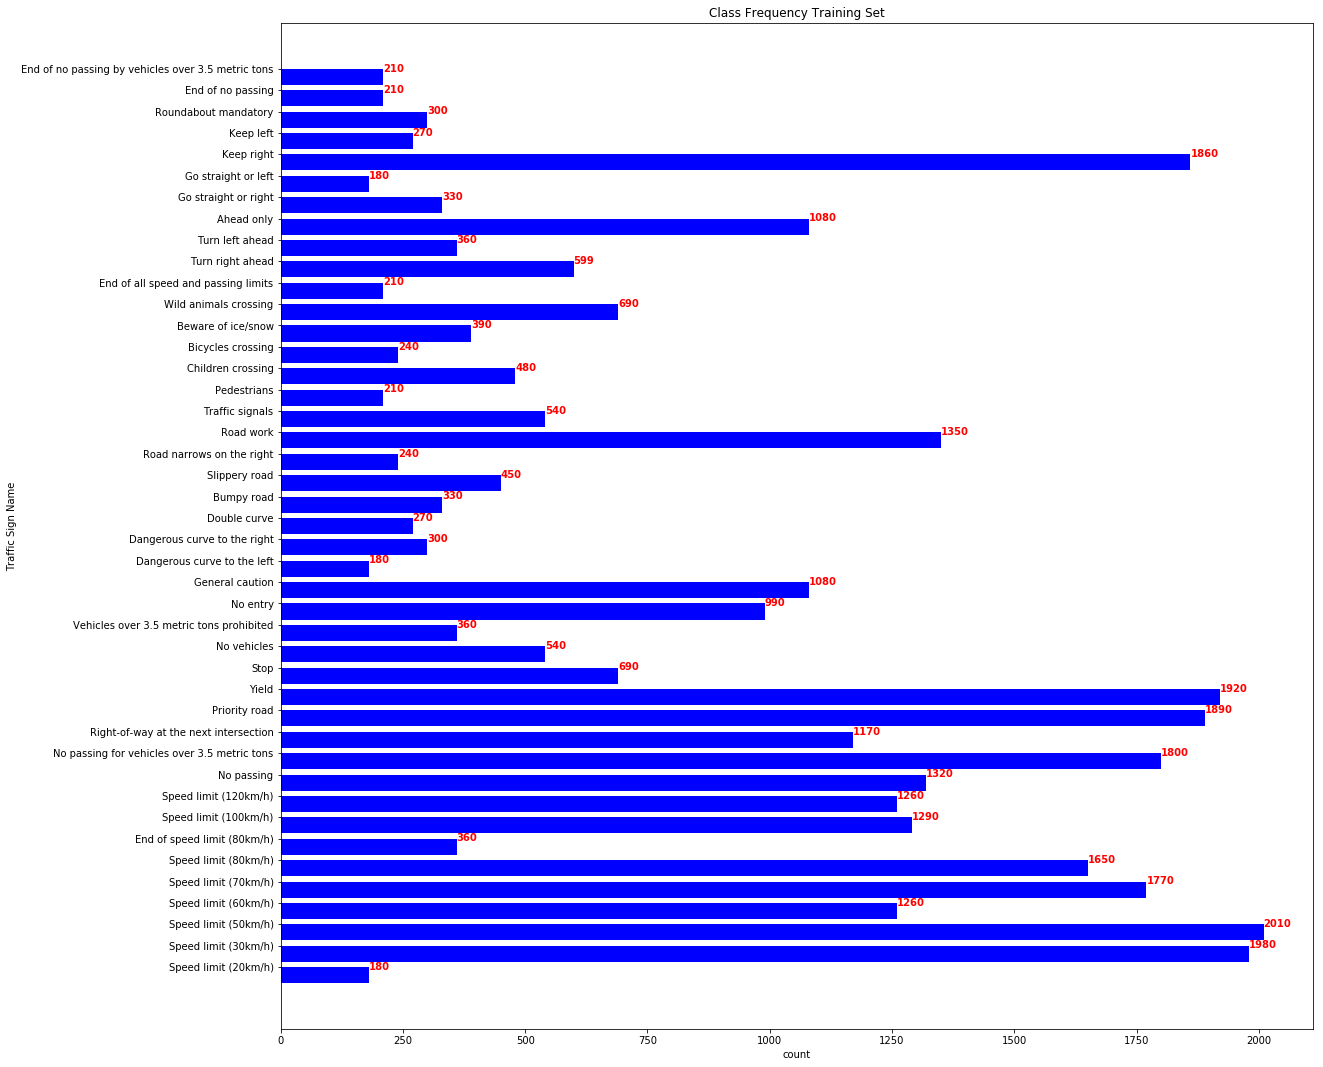

In [92]:
labels, label_counts = np.unique(y_train, return_counts=True)

hbarplot(label_df['SignName'],label_counts,'Class Frequency Training Set','count','Traffic Sign Name')


  

In [93]:
print("class names",label_df['SignName'])


class names 0                                  Speed limit (20km/h)
1                                  Speed limit (30km/h)
2                                  Speed limit (50km/h)
3                                  Speed limit (60km/h)
4                                  Speed limit (70km/h)
5                                  Speed limit (80km/h)
6                           End of speed limit (80km/h)
7                                 Speed limit (100km/h)
8                                 Speed limit (120km/h)
9                                            No passing
10         No passing for vehicles over 3.5 metric tons
11                Right-of-way at the next intersection
12                                        Priority road
13                                                Yield
14                                                 Stop
15                                          No vehicles
16             Vehicles over 3.5 metric tons prohibited
17                                  

## Step 1:Data Augmentation

Given the limited number of training samples, its hard to capture all variations in the data to make the neural network insensitive to it. Following data augmentation techniques make the NN robust.
1. Histogram Equalization: BY training the NN agaist various brightness conditions, we can make it insensitive to brightness information.
2. Random Rotation & scaling 
3. Sharpening / Blurring 

#### Histogram Equalization 


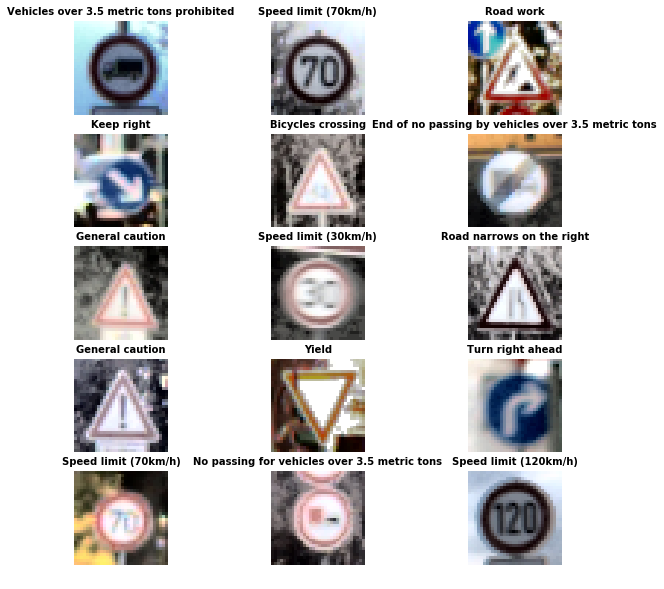

In [94]:
images = []
for image in images_sample:
    image_equalized = histogram_equalization(image)
    images.append(image_equalized)

show_images_with_title(images,cols = 3,titles = titles)

#### Random Rotation 

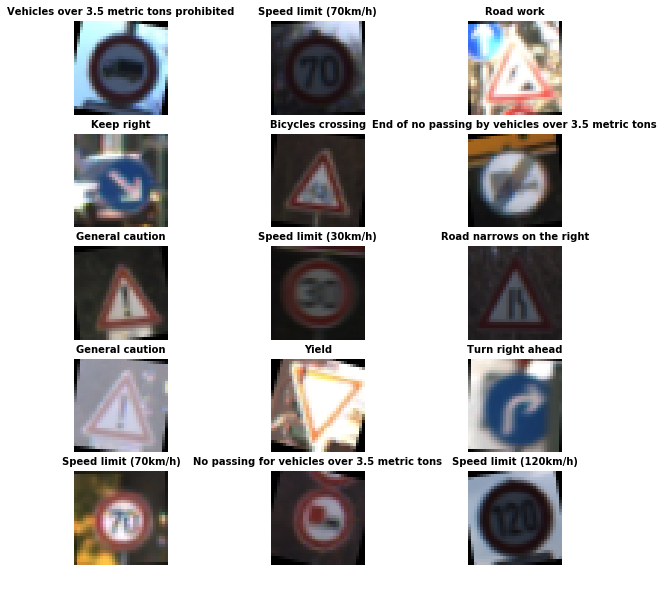

In [95]:
images = []
for image in images_sample:
    images.append(rand_rotation(image))
    
show_images_with_title(images,cols = 3,titles = titles)

#### Random Scaling 

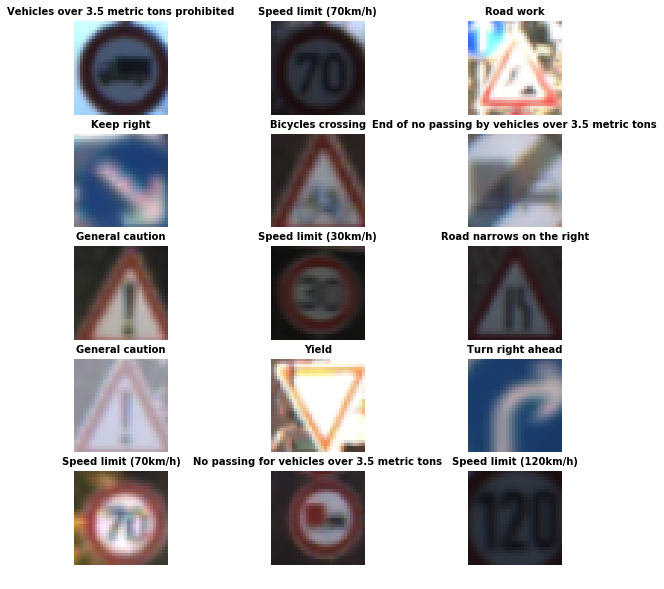

In [96]:
images = []
for image in images_sample:
    scaled = rand_scaling(image)
    cropped_image= crop32x32(scaled)
    images.append(cropped_image)
show_images_with_title(images,cols = 3,titles = titles)

#### Sharpening

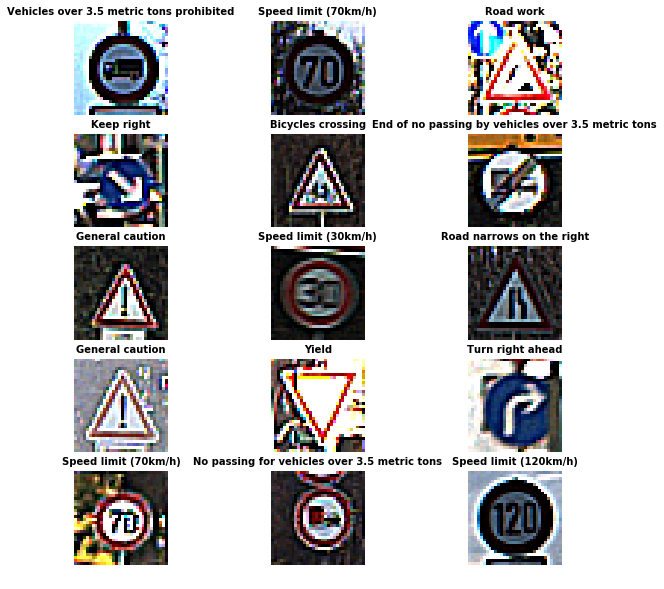

In [97]:
images = []
for image in images_sample:
    images.append(sharpen(image))
    

show_images_with_title(images,cols = 3,titles = titles)

In [98]:
## load augmented data 

X_train_gns = np.load('../data/X_train_aug_norm_15000.npy')
y_train_gns = np.load('../data/y_train_aug_15000.npy')

In [99]:
X_test_gns,y_test_gns =grayscale_normalize_shuffle(X_test,y_test)


## Step 2:Neural Network Architecture

###  Evolution of the solution

The model architecture were evolved through multiple steps. 
1. Basic Lenet NN with color inputs: Train: 0.984063410622	Test:0.769126983862
        * convolution 1 filter 5x5x6
        * maxpooling stride 2
        * convolution 2 filter 5x5x16
        * maxpooling stride 2
        * dense 1 120
        * dropout(0.25)
        * dense 2 84
        * dropout(0.25)
        * dense output
        
 epochs 100
  This is the basic lenet architecture. The NN struggled to improve the test accuracy as I tried various combinations of adding drop out layers, changing the epochsm, adding dense layer 2. I was using the (32x32X3) color inouts assuming that color is important characteristic for signs.

2. Grayscale inputs. Train:0.9958501479	Test:0.9316666675
    Changing the inputs to gray scale greatly improves the accuracy. It seemed counterintuitive to lose all the additional color information but turns out shape of the signs is more important characteristic in classifying signs.
    
3. Augmentation of input: Train:0.9972333875	Test:0.9268766407 
    Based on previous train and test accuracies it was clear that the NN was overfitting. Augmentation of the training set is a great way to reduce the overfitting. Three different operations were peformed to augment the training set which included Histogram equalization, sharpening the image and applying random geometric transformations like scaling, rotation and cropping, increasing the training data threefold. The gains in accuracy were not noticeable. 

4. Multiscaling: Train:0.9904866236 Test:0.9296875
Based on the idea of multiscaling presented by LeCunn et al.in [Traffic Sign Recognition with Multi-Scale Convolutional Networks](http://yann.lecun.com/exdb/publis/pdf/sermanet-ijcnn-11.pdf), the output from the convolution layers was combined as input to the dense layer 1. 
![Go Deeper](http://i0.kym-cdn.com/photos/images/facebook/000/531/557/a88.jpg)

5. Adding Layers:Train: 0.986397603 Test: 0.954161352
Adding additional layers greatly bumped up the test accuracy!.  This along with using [dropout and L2 regularization](https://www.cs.toronto.edu/~hinton/absps/JMLRdropout.pdf) gave an overall accuracy of 95%. The final network consists of three blocks of (2 convolutional layers with max pooling and dropout), the outputs of which are concatenated as input to dense layer 1.  

        * convolution 1 filter 3x3x16
        * convolution 2 filter 3x3x32
        * maxpooling stride 2
        * dropout(0.45)
        
        * convolution 1 filter 3x3x64
        * convolution 2 filter 5x5x128
        * maxpooling stride 2
        * dropout(0.35)
        
        * convolution 1 filter 3x3x256
        * convolution 2 filter 5x5x512
        * maxpooling stride 1
        * dropout(0.25)
        
        * dense 1 120
        * dropout(0.15)
        
        * dense 2 84
        * dropout(0.1)
        
        * dense output 43
        

Set Neural Network Hyper Parameters

In [100]:
tf.reset_default_graph()
epochs = 90
batch_size = 128
beta = 0.001
display_progress = 40
mu = 0
sigma = 0.1

rate = 0.0009

Set parameters for each layer 

In [101]:
input_side_length = 32

# Convolutional Layer 0
n_conv_0 = 16 # depth of conv layer 1
k_conv_0 = 3 # kernel size conv layer 1
stride_length_1 = 1

# Convolutional Layer 1
n_conv_1 = 32 # depth of conv layer 1
k_conv_1 = 3 # kernel size conv layer 1
stride_length_0 = 1

conv_layer_dropout_1 = 0.45

# Convolutional Layer 2
n_conv_2 = 64 # depth of conv layer 2
k_conv_2 =  3 # kernel size of conv layer 2
stride_length_2 = 1

# Convolutional Layer 3
n_conv_3 = 128 # depth of conv layer 2
k_conv_3 =  3 # kernel size of conv layer 2
stride_length_3 = 1

conv_layer_dropout_2 = 0.35

# Convolutional Layer 3
n_conv_4 = 256 # depth of conv layer 2
k_conv_4 =  3 # kernel size of conv layer 2
stride_length_4 = 1

# Convolutional Layer 3
n_conv_5 = 512 # depth of conv layer 2
k_conv_5 =  3 # kernel size of conv layer 2
stride_length_5 = 1

conv_layer_dropout_3 = 0.25


# max pooling layer 1
pool_size_1 = 2
pool_size_2 = 2
pool_size_3 = 1

# dense layer 1
n_dense_1 = 120
dense_layer_dropout_1 = 0.15

# dense layer 2
n_dense_2 = 84
dense_layer_dropout_2 = 0.1

# output layer
n_classes = 43


#### Define Placeholder Tensors 


In [102]:
x = tf.placeholder(tf.float32,(None,32,32,1), name='x')
y = tf.placeholder(tf.int32,(None),name='y')
one_hot_y = tf.one_hot(y, n_classes)


#### Define Layer Types 

In [103]:
# convolutional layer with ReLU
def conv2d(x,W,b,stride_length = 1):
    xW = tf.nn.conv2d(x,W,strides = [1, stride_length,stride_length,1], padding ='VALID')
    z = tf.nn.bias_add(xW,b)
    a = tf.nn.relu(z)
    return a

# dense layer with ReLU
def dense(x,W,b):
    z = tf.add(tf.matmul(x,W),b)
    a = tf.nn.relu(z)
    return a


# max pooling layer
def maxpooling2d(x, pool_size):
    return tf.nn.max_pool(x,ksize=[1,pool_size,pool_size,1],
                         strides=[1,pool_size,pool_size,1],
                         padding='VALID')


#### Define Lenet Architecture 


In [104]:
def LeNet(x, weights, biases, mp_pool_size_1, mp_pool_size_2,mp_pool_size_3, conv_dropout_1,conv_dropout_2,conv_dropout_3, dropout_1, dropout_2):
    
    # convolutional layers block 1 ( 2 conv with relu + 1 maxpool)
    conv_0 = conv2d(x, weights['W_c0'], biases['b_c0'])
    conv_1 = conv2d(conv_0, weights['W_c1'], biases['b_c1'])
    conv_1 = tf.nn.dropout(conv_1, 1 - conv_dropout_1)
    max_pool_1 = maxpooling2d(conv_1, mp_pool_size_1)
    
    # convolutional layers block 2 ( 2 conv with relu + 1 maxpool)
    conv_2 = conv2d(max_pool_1, weights['W_c2'], biases['b_c2'])
    conv_3 = conv2d(conv_2, weights['W_c3'], biases['b_c3'])
    conv_3 = tf.nn.dropout(conv_3, 1 - conv_dropout_2)
    max_pool_2 = maxpooling2d(conv_3, mp_pool_size_2)

    # convolutional layers block 3 ( 2 conv with relu + 1 maxpool)
    conv_4 = conv2d(max_pool_2, weights['W_c4'], biases['b_c4'])
    conv_5 = conv2d(conv_4, weights['W_c5'], biases['b_c5'])
    conv_5 = tf.nn.dropout(conv_5, 1 - conv_dropout_3)
    max_pool_3 = maxpooling2d(conv_5, mp_pool_size_3)

    # concatenating multiscale outputs
    flat = flatten(max_pool_1)
    flat_2 = flatten(max_pool_2)
    flat_3 = flatten(max_pool_3)
    dense_concat = tf.concat([flat, flat_2, flat_3],axis=1)

    # dense layer 1
    dense_1 = dense(dense_concat, weights['W_d1'], biases['b_d1'])
    dense_1 = tf.nn.dropout(dense_1, 1-dropout_1)

     # dense layer 2
    dense_2 = dense(dense_1,weights['W_d2'],biases['b_d2'])
    dense_2 = tf.nn.dropout(dense_2, 1-dropout_2)

    # dense output layer
    logits = tf.add(tf.matmul(dense_2, weights['W_out']), biases['b_out'])

    return logits

#### Define Dictionaries 

In [105]:
bias_dict = {
    'b_c0': tf.Variable(tf.zeros([n_conv_0])),
    'b_c1': tf.Variable(tf.zeros([n_conv_1])),
    'b_c2': tf.Variable(tf.zeros([n_conv_2])),
    'b_c3': tf.Variable(tf.zeros([n_conv_3])),
    'b_c4': tf.Variable(tf.zeros([n_conv_4])),
    'b_c5': tf.Variable(tf.zeros([n_conv_5])),
    'b_d1': tf.Variable(tf.zeros([n_dense_1])),
    'b_d2': tf.Variable(tf.zeros([n_dense_2])),
    'b_out': tf.Variable(tf.zeros([n_classes]))
}


# calculating the sizes

# conv block 1
conv_0_op_side_length = math.ceil((input_side_length - k_conv_0 + 1) / stride_length_0)
conv_1_op_side_length = math.ceil((conv_0_op_side_length - k_conv_1 + 1) / stride_length_1)
print(conv_1_op_side_length)
pooled_side_length_1 = int(conv_1_op_side_length / pool_size_1)
print(pooled_side_length_1)

# conv block2
conv_2_op_side_length = math.ceil((pooled_side_length_1 - k_conv_2 + 1) / stride_length_2)
conv_3_op_side_length = math.ceil((conv_2_op_side_length - k_conv_3 + 1) / stride_length_3)
pooled_side_length_2 = int(conv_3_op_side_length / pool_size_2)

# conv block 3
conv_4_op_side_length = math.ceil((pooled_side_length_2 - k_conv_4 + 1) / stride_length_4)
conv_5_op_side_length = math.ceil((conv_4_op_side_length - k_conv_5 + 1) / stride_length_5)
pooled_side_length_3 = int(conv_5_op_side_length / pool_size_3)

# dense layer 1
dense_input_1 = pooled_side_length_2 * pooled_side_length_2 * n_conv_3 + pooled_side_length_1 * pooled_side_length_1 * n_conv_1 + pooled_side_length_3 * pooled_side_length_3 * n_conv_5
print(dense_input_1)


weight_dict = {
    'W_c0': tf.get_variable('W_c0', initializer=tf.truncated_normal(shape=(k_conv_0, k_conv_0, 1, n_conv_0), mean=mu, stddev=sigma)),
    'W_c1': tf.get_variable('W_c1', initializer=tf.truncated_normal(shape=(k_conv_1, k_conv_1, n_conv_0, n_conv_1), mean=mu, stddev=sigma)),
    'W_c2': tf.get_variable('W_c2', initializer=tf.truncated_normal(shape=(k_conv_2, k_conv_2, n_conv_1, n_conv_2), mean=mu, stddev=sigma)),
    'W_c3': tf.get_variable('W_c3', initializer=tf.truncated_normal(shape=(k_conv_3, k_conv_3, n_conv_2, n_conv_3), mean=mu, stddev=sigma)),
    'W_c4': tf.get_variable('W_c4', initializer=tf.truncated_normal(shape=(k_conv_4, k_conv_4, n_conv_3, n_conv_4), mean=mu, stddev=sigma)),
    'W_c5': tf.get_variable('W_c5', initializer=tf.truncated_normal(shape=(k_conv_5, k_conv_5, n_conv_4, n_conv_5), mean=mu, stddev=sigma)),
    'W_d1': tf.get_variable('W_d1', initializer=tf.truncated_normal(shape=(dense_input_1, n_dense_1), mean=mu, stddev=sigma)),
    'W_d2': tf.get_variable('W_d2', initializer=tf.truncated_normal(shape=(n_dense_1, n_dense_2), mean=mu, stddev=sigma)),
    'W_out': tf.get_variable('W_out', initializer=tf.truncated_normal(shape=(n_dense_2, n_classes), mean=mu, stddev=sigma))
}


28
14
9984


#### Build Model


In [106]:
logits = LeNet(x, weight_dict, bias_dict,
                      pool_size_1,pool_size_2,pool_size_3,
                    conv_layer_dropout_1, conv_layer_dropout_2,conv_layer_dropout_3,
                   dense_layer_dropout_1, dense_layer_dropout_2)



softmax_probabilities = tf.nn.softmax(logits,name="softmax_probabilities")
prediction_operation = tf.argmax(logits, 1,name='prediction_operation')

#### Define functions

In [107]:
softmax_probabilities = tf.nn.softmax(logits,name="softmax_probabilities")
prediction_operation = tf.argmax(logits, 1,name='prediction_operation')

#### Model Loss and Optimizer

In [109]:

W_c0_ext = [v for v in tf.trainable_variables() if v.name == "W_c0:0"][0]
W_c1_ext = [v for v in tf.trainable_variables() if v.name == "W_c1:0"][0]
W_c2_ext = [v for v in tf.trainable_variables() if v.name == "W_c2:0"][0]
W_c3_ext = [v for v in tf.trainable_variables() if v.name == "W_c3:0"][0]
W_c4_ext = [v for v in tf.trainable_variables() if v.name == "W_c4:0"][0]
W_c5_ext = [v for v in tf.trainable_variables() if v.name == "W_c5:0"][0]
W_d1_ext = [v for v in tf.trainable_variables() if v.name == "W_d1:0"][0]
W_d2_ext = [v for v in tf.trainable_variables() if v.name == "W_d2:0"][0]
W_out_ext = [v for v in tf.trainable_variables() if v.name == "W_out:0"][0]

cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=logits, labels=one_hot_y)+
                      beta*tf.nn.l2_loss(W_c0_ext)+beta*tf.nn.l2_loss(W_c1_ext)+
                      beta * tf.nn.l2_loss(W_c2_ext)+beta*tf.nn.l2_loss(W_c3_ext)+
                      beta * tf.nn.l2_loss(W_c4_ext)+beta*tf.nn.l2_loss(W_c5_ext)+
                      beta*tf.nn.l2_loss(W_d1_ext)+beta*tf.nn.l2_loss(W_d2_ext)+
                      beta*tf.nn.l2_loss(W_out_ext)) # choose the cost function
optimizer = tf.train.AdamOptimizer(learning_rate = rate) # choose optimizer
training_operation = optimizer.minimize(cost)


#####  Evaluation Metrics


In [110]:


correct_prediction = tf.equal(tf.argmax(logits, 1), tf.argmax(one_hot_y, 1))
accuracy_pct = tf.reduce_mean(tf.cast(correct_prediction, tf.float32),name= 'accuracy_pct')


#### Train the network 

In [113]:
config = tf.ConfigProto()
config.gpu_options.allow_growth = True
saver = tf.train.Saver()

logging.info('Training,Testing')
ticking_on = time.time()
with tf.Session(config=config) as session:
    session.run(tf.global_variables_initializer())
    # Training Operation
    print("Training for ", epochs, "epochs")
    MAX_ACCURACY = 0
    MAX_ACCURACY_EPOCH = 0
    for epoch in range(epochs):

        average_cost = 0.0
        average_accuracy_pct = 0.0
        num_batches = int(X_train_gns.shape[0] / batch_size)
        offset = 0
        accuracy = 0
        for i in range(num_batches):
            #if i % display_progress == 0:
             #   print("Training Step ", i + 1, " of ", num_batches, " in Epoch", epoch + 1, ".")

            end = offset + batch_size
            batch_x, batch_y = X_train_gns[offset:end], y_train_gns[offset:end]
            _, batch_cost, batch_acc = session.run([training_operation, cost, accuracy_pct],
                                                   feed_dict={x: batch_x, y: batch_y})

            offset = end
            # Calculate average Costs
            accuracy += batch_acc
        train_average_accuracy_pct = accuracy / num_batches
        #logging.info("Training: %.4f"train_average_accuracy_pct)

        print("Average training accuracy after Epoch", epoch + 1, " is ", train_average_accuracy_pct)

        num_batches = int(X_test_gns.shape[0] / batch_size)
        offset = 0
        accuracy = 0
        for i in range(num_batches):
            #if i % display_progress == 0:
             #   print("Validation Step ", i + 1, " of ", num_batches,".")

            end = offset + batch_size
            batch_x, batch_y = X_test_gns[offset:end], y_test_gns[offset:end]
            batch_acc = session.run(accuracy_pct,feed_dict={x: batch_x, y: batch_y})
            offset = end
            # Calculate average Costs
            accuracy += batch_acc
        test_average_accuracy_pct = accuracy / num_batches
        if MAX_ACCURACY<test_average_accuracy_pct:
            MAX_ACCURACY=test_average_accuracy_pct
            MAX_ACCURACY_EPOCH = epoch
        logging.info("%.6f,%.6f",train_average_accuracy_pct,test_average_accuracy_pct)
        print("Validation Accuracy", test_average_accuracy_pct)
    save_path = saver.save(session, "../model/Lenet")
    print("Model saved in path: %s" % save_path)
    logging.info("Max Accuracy is %.6f at epoch %d", MAX_ACCURACY, MAX_ACCURACY_EPOCH)


ticking_off = time.time()
print( (ticking_off - ticking_on) )

Training for  90 epochs
Average training accuracy after Epoch 1  is  0.647202322134
Validation Accuracy 0.883290816327
Average training accuracy after Epoch 2  is  0.93377902668
Validation Accuracy 0.91549744898
Average training accuracy after Epoch 3  is  0.956321022727
Validation Accuracy 0.935347576531
Average training accuracy after Epoch 4  is  0.964010004941
Validation Accuracy 0.940210459184
Average training accuracy after Epoch 5  is  0.969274950593
Validation Accuracy 0.930644132653
Average training accuracy after Epoch 6  is  0.970587327075
Validation Accuracy 0.937021683673
Average training accuracy after Epoch 7  is  0.973644392292
Validation Accuracy 0.947624362245
Average training accuracy after Epoch 8  is  0.974848690711
Validation Accuracy 0.945073341837
Average training accuracy after Epoch 9  is  0.975327322134
Validation Accuracy 0.936144770408
Average training accuracy after Epoch 10  is  0.976948493083
Validation Accuracy 0.934630102041
Average training accuracy a

Validation Accuracy 0.95240752551
Average training accuracy after Epoch 87  is  0.986212327075
Validation Accuracy 0.948421556122
Average training accuracy after Epoch 88  is  0.986799036561
Validation Accuracy 0.957987882653
Average training accuracy after Epoch 89  is  0.986289525692
Validation Accuracy 0.949537627551
Average training accuracy after Epoch 90  is  0.985795454545
Validation Accuracy 0.95774872449
Model saved in path: ../model/Lenet
8233.823287248611


##### Validate the  model 


### Results Discussion

#### 1. Lenet with Color Inputs:
In the first implementation of the NN I started off with color inputs. The hypothesis was that color information is useful to distinguish signs since signs have distint colors. 
Epochs = 10 Channels 3 
ConvLayer
#### 2. Lenet with Drop Out Layer 1
The Neural Network showed decreased peformance when additional layers were added. 

Conv->Conv->Dense-> Out	98.9275362319
Conv->Conv->Dense-> Dense-> Out	98.6956521739
Conv->Conv->Dense-> Droput_>Out Epoch 100	98.0144927536


In [ ]:
# Saving the model. 

## Step 3:Test a model on new Images

A set of 15 images were selected from the web. The images have interesting combinations of distortion, scaling and variety.

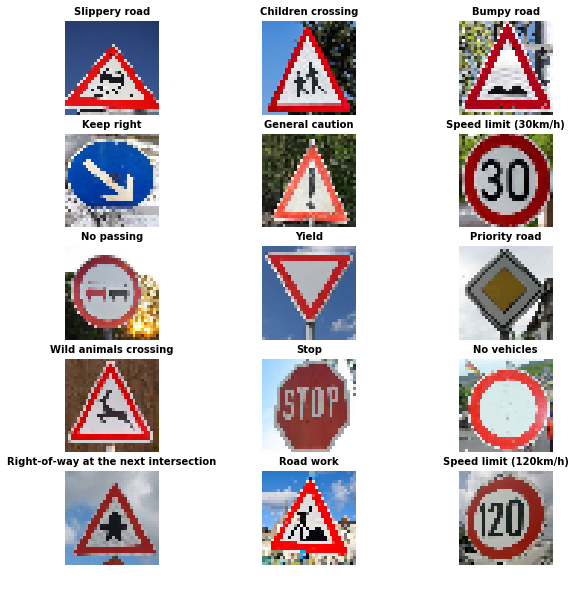

In [114]:
df=pd.read_csv('../data/newsigns/true.csv')
#print(df)
images = []
titles = []
for index, row in df.iterrows():
    image = cv2.imread(row['file'])
    image_resized= cv2.resize(image,(32,32))
    images.append(bgr2rgb(image_resized))
    true_id = int(row['truelabel'])
    titles.append(label_df['SignName'][true_id])

show_images_with_title(images,cols = 3, titles = titles)

In [115]:
X_new = np.array(images)
X_new_gray =  np.sum(X_new/2, axis = 3,keepdims = True)
X_new_normalized = (X_new_gray - 128)/128 
print(X_new_gray.shape)

(15, 32, 32, 1)


In [116]:
tf.reset_default_graph()


#y_new_true = [18,9,12,11,25]
# create a new saver
with tf.Session() as session:
    saver = tf.train.import_meta_graph('../model/Lenet.meta')
    saver.restore(session,tf.train.latest_checkpoint('../model/'))
    graph = tf.get_default_graph()
    x = graph.get_tensor_by_name("x:0")
    prediction_operation = graph.get_tensor_by_name("prediction_operation:0")
    classifcation = session.run(prediction_operation,feed_dict={x:X_new_normalized})
    print(label_df['SignName'][classifcation])

INFO:tensorflow:Restoring parameters from ../model/Lenet
23                            Slippery road
24                Road narrows on the right
22                               Bumpy road
38                               Keep right
18                          General caution
1                      Speed limit (30km/h)
9                                No passing
13                                    Yield
12                            Priority road
31                    Wild animals crossing
14                                     Stop
15                              No vehicles
11    Right-of-way at the next intersection
25                                Road work
0                      Speed limit (20km/h)
Name: SignName, dtype: object


In [117]:
cc = np.array(classifcation)




### Classifying new images. 
The nn performs well on the new images. Classifying 14 out 15 images correctly. The misclassified sign "Speed Limit (120kmh)" is classified as ""Speed Limit (20kmh)". The nn should be confused by this one because the two signs are visually very similar. 

The model is able to perform well on selected images.

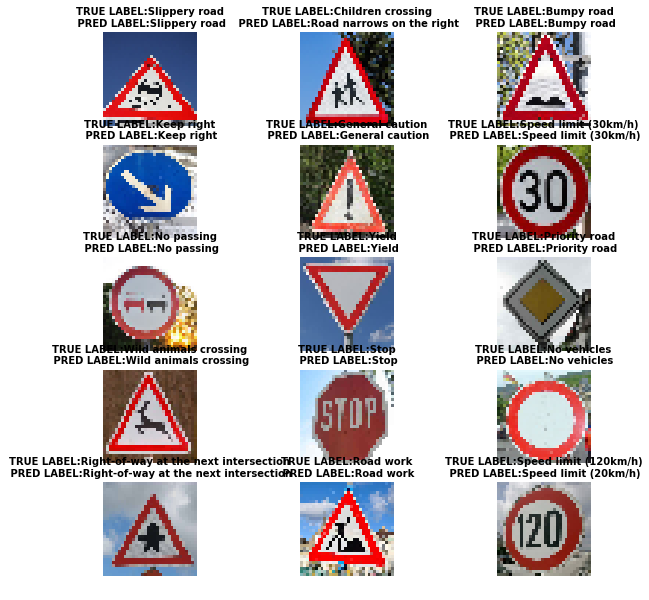

In [118]:


df=pd.read_csv('../data/newsigns/true.csv')
df['predictedlabel'] = cc


titles = []
for index, row in df.iterrows():
    true_id = int(row['truelabel'])
    pred_id = int(row['predictedlabel'])
    title = "TRUE LABEL:"+label_df['SignName'][true_id]+"\n PRED LABEL:"+label_df['SignName'][pred_id]
    titles.append(title)

show_images_with_title(images,cols = 3, titles = titles)


## Step 4: Visualize Softmax probabilities
The model is able to classify the chosen new signs with high probability. 

In [ ]:
tf.reset_default_graph()


# create a new saver
with tf.Session() as session:
    saver = tf.train.import_meta_graph('../model/Lenet.meta')
    saver.restore(session,tf.train.latest_checkpoint('../model/'))
    graph = tf.get_default_graph()
    x = graph.get_tensor_by_name("x:0")
    softmax_probabilities = graph.get_tensor_by_name("softmax_probabilities:0")
    top_5_softmax_op = tf.nn.top_k(softmax_probabilities,k=5)
    top_5_softmax = session.run(top_5_softmax_op,feed_dict={x:X_new_normalized})
   # print(top_5_softmax.values)
   # print(top_5_softmax.indices)

INFO:tensorflow:Restoring parameters from ../model/Lenet


In [ ]:
values_df = pd.DataFrame(top_5_softmax.values)
indices_df = pd.DataFrame(top_5_softmax.indices)
y_new_true = [18,9,12,11,25]

for index, row in values_df.iterrows():
    title_str = 'softmax probabilities for Class ID ' + str(y_new_true[index])
    labels = indices_df.iloc[[index]].values
    hbarplot(labels[0],row.values, title = title_str, xlabel = 'probability',ylabel ='class ID',xsize =10,ysize=10)
 
print(label_df['SignName'][0])


## Step 5: Confusion Matrix and Precision-Recall

In [ ]:
batch_size = 25
display_progress = 40


def get_predictions(X_validation):
    num_batches = int(X_validation.shape[0] / batch_size)+1
    offset = 0
    y_prediction = []
    for i in range(num_batches):
        if i % display_progress == 0:
            print("prediction Step ", i + 1, " of ", num_batches,".")
        end = offset + batch_size
        batch_x = X_validation[offset:end]
        batch_predicted_y = session.run(prediction_operation,feed_dict={x: batch_x})
        offset = end
        y_prediction = np.concatenate([y_prediction,batch_predicted_y])
    return  y_prediction.astype(int)


tf.reset_default_graph()
with tf.Session() as session:
    saver = tf.train.import_meta_graph('../model/Lenet.meta')
    saver.restore(session,tf.train.latest_checkpoint('../model/'))
    graph = tf.get_default_graph()
    prediction_operation = graph.get_tensor_by_name("prediction_operation:0")
    x = graph.get_tensor_by_name("x:0")
    y = graph.get_tensor_by_name("y:0")
    y_predicted = get_predictions(X_test_norm)
    print(y_predicted.shape)
    print(y_test.shape)
    cm_operation = tf.contrib.metrics.confusion_matrix(y_test, y_predicted)
    cm = session.run(cm_operation)
    print(cm.shape)

### Confusion Matrix
The confusion matrix is a good visual representation of the performance of the NN. The diagonal of the confusion matrix represents the True positives. 

Observations:
1. Rows: Its easy to quickly see what a particular sign is misclassified as by looking at the row in the figure below. For example "Right of way at the next interesection" is misclassified as "Beware of ice and snow"
2. Columns: Looking along the column, you can see what other signs can be wrongly classified as that sign. For example classification "Pedestrains" could mean a "General Caution" that has beed miscalssified.
 

In [ ]:
from sklearn.preprocessing import normalize
cm_f = np.array(cm).astype(float)
normed_cm = normalize(cm_f, axis=0, norm='l1') ## Rowise normalization get 

fig, ax = plt.subplots(figsize=(20, 20))
res = plt.imshow(normed_cm, interpolation='nearest')
plt.xticks(np.arange(0,len(label_df['SignName'])), label_df['SignName'],rotation=90)
plt.yticks(np.arange(0,len(label_df['SignName'])), label_df['SignName'])
cb = fig.colorbar(res)
width, height = normed_cm.shape

for x in range(width):
    for y in range(height):
        ax.annotate(str(cm[x][y]), xy=(y, x), 
                    horizontalalignment='center',
                    verticalalignment='center')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix with count of instances')
#print(label_df['SignName'])

### Precision and Recall: 
Precision addresses the question "Given a positive example from a classifier, how likely is it to be correct ?"
while recall addresses the question "Given a positive example, will the classifier detect it. 

Interesting observations: 
1. High Precision Low Recall : "Speed limit (20kmph)" has high precision but low recall. If nn classifies the sign as "Speed limit (20kmph" There is a high chance it is true but the low recall means it will mis classify "Speed limit (20kmph" as some thing else. The "Speed limit (20kmph" has a high change of being misclassified as "Speed limit (70kmph)" as seen in the confusion matrix.
From the self driving car perspective, if the nn classifies the sign with high precision, I would have high confidence that it is true. A low recall value means the sign was recognized as another sign, which could be dangerous.

2. High Recall Low Precision: "Traffic signals" has high recall but low precision. This means the NN was able to identify most of the signs which were "Traffic signals" but many times what was classified as "Traffic signals" was another class. Looking athe confusion matrix, signs with Label "General Caution" were misclassified as "Traffic signals".From the self driving car perspective, if the nn classifies the sign with low precision means that there is a high change that it can be another sign. A high recall value indicates that the nn will recognize the sign most of the time it is presented.



In [ ]:
_, true_label_counts = np.unique(y_test, return_counts=True)
_, predicted_label_counts = np.unique(y_predicted, return_counts=True)

true_positives = np.diagonal(cm)
precision = true_positives/predicted_label_counts
recall = true_positives/true_label_counts


df_pnr = pd.DataFrame(data={'labels':label_df['SignName'],'precision':precision ,'recall':recall})
#print(df_pnr)
#hbarplot(label_df['SignName'],precision,'Precision','precision','Traffic Sign Name')

 
# create plot
fig, ax = plt.subplots()
fig.set_size_inches(18.5, 18.5)
index = np.arange(n_classes)
bar_width = 0.35
opacity = 0.8

rects1 = plt.barh(index, precision, bar_width,
                 alpha=opacity,
                 color='b',
                 label='Precision')
 
rects2 = plt.barh(index + bar_width, recall, bar_width,
                 alpha=opacity,
                 color='g',
                 label='Recall')
plt.xlabel('Precision and Recall')
plt.ylabel('Traffic Signs')
plt.title('Precison and Recall')
plt.yticks(index + bar_width, label_df['SignName'])
plt.legend()
 
lt.tight_layout()